In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import swan_vis as swan


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
ab = '../../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'isos_sample_gene_90.tsv'
swan_file = 'swan.p'

In [3]:
# df = pd.read_csv(ab, sep='\t')
# df, inds = get_tpm_table(df,
#                    how='gene',
#                    min_tpm=min_tpm,
#                    gene_subset='polya')

# # need stable gid
# df.head()
# df['temp_tid'] = df.index.tolist()
# inds = cerberus.get_stable_gid(df, col='temp_tid')
# inds[:5]

# temp = pd.DataFrame()
# temp['gids'] = inds
# temp.to_csv('temp_gids_1_tpm.tsv', sep='\t', index=False)

In [4]:
# # get metadata for v40
# gtf = '/Users/fairliereese/mortazavi_lab/data/rnawg/refs/gencode.v40.annotation.gtf'
# o = '/Users/fairliereese/mortazavi_lab/data/rnawg/refs/v40_gene_metadata.tsv'
# get_gene_info(gtf, o)

In [5]:
mane_file = o = '/Users/fairliereese/mortazavi_lab/data/rnawg/refs/v40_gene_metadata.tsv'

In [6]:
# get list of gene inds that are >=1 tpm and 
# had a mane iso
inds = pd.read_csv('temp_gids_1_tpm.tsv', sep='\t')
inds = inds.gids.tolist()

mane = pd.read_csv(mane_file, sep='\t')
mane = mane.loc[mane.MANE_Select == True]
mane['gid'] = cerberus.get_stable_gid(mane, col='gid')
mane = mane.gid.tolist()

In [7]:
inds = list(set(inds)&(set(mane)))
print(len(inds))

17629


In [8]:
obs_col = 'sample'
sg = swan.read('swan.p')

Read in graph from swan.p


In [43]:
def uses_principal_feat(x):
    """
    Agg function to determine if individual feats
    (tss, ic, tes) use the principal version of that 
    feature
    """
    return '1' in x.unique()

def uses_principal_iso(x):
    """
    Agg function to determine if the isoform triplet
    is the principal version of that gene
    """
    return '1,1,1' in x.unique()

def get_major_iso(sg, obs_col='sample', gene_subset=None):
    """
    Determine what the major isoform is in each grouping
    for each gene 
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
            abundance data added
        obs_col (str): Column in `sg.adata.obs` to group
            datasets by 
        gene_subset (list of str or None): If not None, 
            list of stable gene ids to subset on 
            
    Returns:
        df (pandas DataFrame): DF where each row is the major 
            isoform in each expressed gene / sample combination
    """
    df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col=obs_col)
    df = df.sparse.to_dense()
    df = df.transpose()

    t_df = sg.t_df.copy(deep=True)
    t_df.reset_index(drop=True, inplace=True)
    t_df = t_df[['tid', 'gname', 'gid']]
    df = df.merge(t_df, how='inner', on='tid')
    
    df.set_index(['tid', 'gname', 'gid'], inplace=True)
    df = df.melt(ignore_index=False, value_name='pi', var_name=obs_col)
    df = df.dropna(subset=['pi'])
    df.reset_index(inplace=True)
    
    # remove unexpressed isoforms
    df = df.loc[df.pi > 0]
    
    # limit to detected genes
    df['gid_stable'] = cerberus.get_stable_gid(df, 'gid')
    if gene_subset:
        df = df.loc[df.gid_stable.isin(gene_subset)]
        
    # sort by gene, sample, and pi value
    # dedupe across the gene and sample cols; take the top-expressed isoform
    df = df.sort_values(by=['gid', obs_col, 'pi'],
                        ascending=[False, False, False])

    df = df.drop_duplicates(subset=['gname', 'gid', obs_col], keep='first')       
    
    return df

def get_major_principal_feats(sg, **kwargs):
    """
    Determine how many genes have at least one sample where
    the features and full-length isoform is the principal isoform
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                    abundance data added   
                    
    Returns:
        df (pandas DataFrame): DF w/ boolean columns for 
            whether or not there's at least one sample
            where the major feat / isoform is the principal one
    """
    df = get_major_iso(sg, **kwargs)
    
    # add features
    for feat in ['ic', 'tss', 'tes']:
        df = add_feat(df, kind=feat,
                      col='tid',
                      as_number=True,
                      drop_triplet=False)

    # remove unnecessary columns and determine which genes
    # have at least one sample who's major iso uses the principal
    # of each feature
    temp = df.copy(deep=True)
    temp.drop([obs_col, 'tid', 'pi', 'gid'], axis=1, inplace=True)

    temp = temp.groupby(['gname',
                         'gid_stable']).agg({'tss': uses_principal_feat,
                                             'ic': uses_principal_feat,
                                             'tes': uses_principal_feat,
                                             'triplet': uses_principal_iso}).reset_index()

    # output
    for feat in ['ic', 'tss', 'tes', 'triplet']:
        n_genes = len(temp.gid_stable.unique().tolist())
        n_major = len(temp.loc[temp[feat] == True].index)
        print(n_genes)
        print(n_major)
        print(feat)
        print('{:.2f}% of genes have >=1 sample where major isoform contains principal {}'.format((n_major/n_genes)*100, feat))
        print()
        
    return temp

def count_major_principal_feats(sg, **kwargs):
    """
    Count the number of samples that the major isoform
    is the principal isoform and vice versa. Do the same
    for individual features as well.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
            abundance data added
            
    Returns:
        df (pandas DataFrame): DF with # samples per gene 
            that use the principal feature as their major
            feature / iso
    """
    
    df = get_major_iso(sg, **kwargs)
    
    # add features
    for feat in ['ic', 'tss', 'tes']:
        df = add_feat(df, kind=feat,
                      col='tid',
                      as_number=True,
                      drop_triplet=False)
        
    temp = df.copy(deep=True)
    temp.drop(['tid', 'pi', 'gid'], axis=1, inplace=True)

    temp = temp.groupby([obs_col, 'gname',
                        'gid_stable'],
                        observed=True).agg({'tss': uses_principal_feat,
                                            'ic': uses_principal_feat,
                                            'tes': uses_principal_feat,
                                            'triplet': uses_principal_iso}).reset_index()
    
    # convert from detection bool to int so we can sum up
    # also add the opposiite number
    for feat in ['tss', 'ic', 'tes', 'triplet']:
        col = 'not_{}'.format(feat)
        temp[feat] = temp[feat].astype(int)
        temp[col] = (temp[feat] == False).astype(int)

    # count n samples where major != principal and vice versa
    temp = temp.groupby(['gname', 'gid_stable']).sum().reset_index()
    
    # total number of samples that this gene is expressed / 
    # has a complete isoform in 
    temp['n_samples'] = temp.triplet+temp.not_triplet
    
    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'not_{}'.format(feat)
        n_genes = len(temp.gid_stable.unique())
        n_num = len(temp.loc[temp[col] >= 1].index)
        print()
        print('{:.2f}% ({}/{}) genes with >= 1 sample where the major {} is not the principal one'.format((n_num/n_genes)*100, n_num, n_genes, feat)) 
        
    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'perc_{}'.format(feat)
        temp[col] = (temp[feat]/temp.n_samples)*100
        
    return temp

def plot_major_principal_feat_counts(sg, opref='figures/', **kwargs):
    """
    Plot a histogram of the number of datasets where the major isoform
    is the principal isoform.
    
    Parameters:
        sg (swan_vis SwanGraph): SwanGraph with transcript
                abundance data added
    
    Returns:
        temp (pandas DataFrame): Output from `count_major_principal_feats`.
    """
    temp = count_major_principal_feats(sg, **kwargs)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    sns.set_context('paper', font_scale=1.8)
    c_dict, order = get_feat_colors()    
    for feat in ['triplet', 'tss', 'ic', 'tes']:
        col = 'perc_{}'.format(feat)
        ax = sns.displot(data=temp,
                         x=col,
                         linewidth=0, 
                         color=c_dict[feat],
                         binwidth=5,
                         alpha=1)
        ylabel = '# genes'
        if feat in ['tss', 'ic', 'tes']: 
            xlabel = '% of samples where major isoform uses MANE {}'.format(feat.upper())
        else:
            xlabel = '% of samples where major isoform is MANE'
            
        ax.set(ylabel=ylabel, xlabel=xlabel)

        fname = '{}/MANE_vs_major_{}_hist.pdf'.format(opref, feat)
        plt.savefig(fname, dpi=800, bbox_inches='tight')
        
    return temp

In [41]:
temp = count_major_principal_feats(sg, obs_col=obs_col, gene_subset=inds)


82.61% (14015/16966) genes with >= 1 sample where the major triplet is not the principal one

53.02% (8996/16966) genes with >= 1 sample where the major tss is not the principal one

65.09% (11044/16966) genes with >= 1 sample where the major ic is not the principal one

61.23% (10388/16966) genes with >= 1 sample where the major tes is not the principal one


In [28]:
obs_col = 'sample'
get_major_principal_feats(sg, obs_col=obs_col, gene_subset=inds)

16966
15147
ic
89.28% of genes have >=1 sample where major isoform contains principal ic

16966
15710
tss
92.60% of genes have >=1 sample where major isoform contains principal tss

16966
14613
tes
86.13% of genes have >=1 sample where major isoform contains principal tes

16966
11987
triplet
70.65% of genes have >=1 sample where major isoform contains principal triplet



,gname,gid_stable,tss,ic,tes,triplet
0,A1BG,ENSG00000121410,True,True,True,False
1,A1CF,ENSG00000148584,True,False,True,False
2,A2M,ENSG00000175899,True,True,True,True
3,A2ML1,ENSG00000166535,False,False,False,False
4,A4GALT,ENSG00000128274,True,True,True,True
...,...,...,...,...,...,...
16961,ZYG11A,ENSG00000203995,True,True,True,True
16962,ZYG11B,ENSG00000162378,True,True,True,True
16963,ZYX,ENSG00000159840,True,True,True,True
16964,ZZEF1,ENSG00000074755,True,True,True,True


In [29]:
df = count_major_principal_feats(sg, obs_col=obs_col, gene_subset=inds)


82.61% (14015/16966) genes with >= 1 sample where the major triplet is not the principal one

53.02% (8996/16966) genes with >= 1 sample where the major tss is not the principal one

65.09% (11044/16966) genes with >= 1 sample where the major ic is not the principal one

61.23% (10388/16966) genes with >= 1 sample where the major tes is not the principal one


In [30]:
# do we have the correct number of samples? Should be 50
max(df.tss)

50

In [31]:
def get_feat_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    triplet = '#009E73'
    c_dict = {'tss': tss,
              'ic': splicing,
              'tes': tes,
              'triplet': triplet}
    order = ['triplet', 'tss', 'ic', 'tes']
    
    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

In [33]:
sns.set_context('paper', font_scale=1.8)



82.61% (14015/16966) genes with >= 1 sample where the major triplet is not the principal one

53.02% (8996/16966) genes with >= 1 sample where the major tss is not the principal one

65.09% (11044/16966) genes with >= 1 sample where the major ic is not the principal one

61.23% (10388/16966) genes with >= 1 sample where the major tes is not the principal one


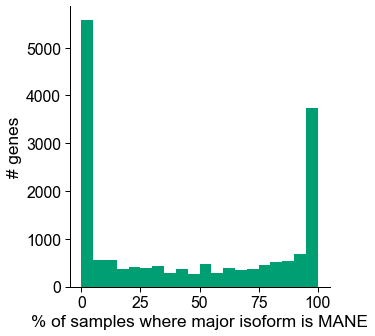

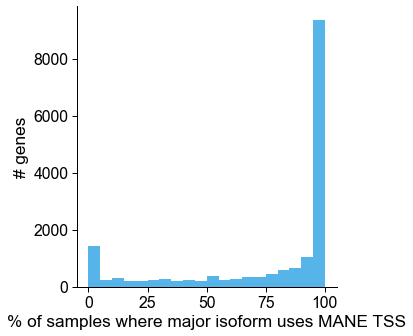

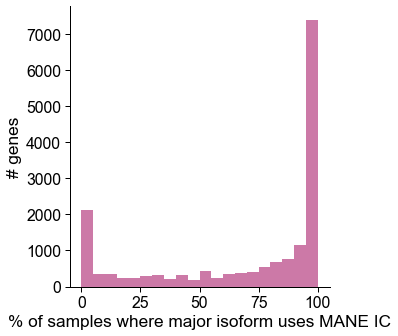

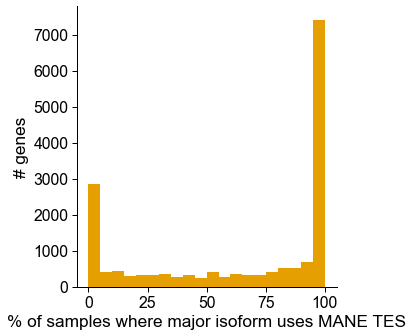

In [44]:
df = plot_major_principal_feat_counts(sg, opref='figures/', obs_col=obs_col, gene_subset=inds)